In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
import torchvision
from torchvision.transforms.functional import to_pil_image
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
h, w = 64, 64
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

transform = transforms.Compose([
                    transforms.Resize((h,w)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
])

In [ ]:
train_data = datasets.STL10('./data',  download = True,split = 'train',transform = transform)

Files already downloaded and verified


In [ ]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

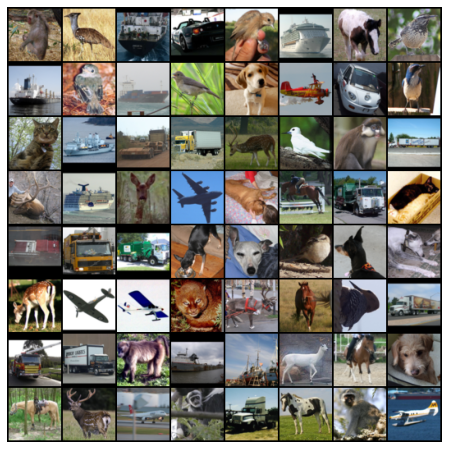

In [ ]:
batch = iter(train_loader).next()
plt.figure(figsize = (8,8))
plt.axis('off')
plt.imshow(make_grid(batch[0], normalize = True).permute(1,2,0))

In [ ]:
params = {'nz':100, # noise 수
          'ngf':64, # generator에서 사용하는 conv filter 수
          'ndf':64, # discriminator에서 사용하는 conv filter 수
          'img_channel':3, # 이미지 채널
          }

In [ ]:
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        nz = params['nz'] # noise 수, 100
        ngf = params['ngf'] # conv filter 수
        img_channel = params['img_channel'] # 이미지 채널 수

        self.dconv1 = nn.ConvTranspose2d(nz,ngf*8,4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*8)
        self.dconv2 = nn.ConvTranspose2d(ngf*8,ngf*4, 4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf*4)
        self.dconv3 = nn.ConvTranspose2d(ngf*4,ngf*2,4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(ngf*2)
        self.dconv4 = nn.ConvTranspose2d(ngf*2,ngf * 1,4,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(ngf*1)
        self.dconv5 = nn.ConvTranspose2d(ngf,img_channel,4,stride=2,padding=1,bias=False)


    def forward(self,x):
        x = F.relu(self.bn1(self.dconv1(x)))
        x = F.relu(self.bn2(self.dconv2(x)))
        x = F.relu(self.bn3(self.dconv3(x)))
        x = F.relu(self.bn4(self.dconv4(x)))
        x = torch.tanh(self.dconv5(x)) #마지막 tanh
        return x

# 사이즈확인
x = torch.randn(1,100,1,1, device=device)
generator = Generator(params).to(device)
output = generator(x)
print(output.shape)

torch.Size([1, 3, 64, 64])


In [ ]:
class Discriminator(nn.Module):
    def __init__(self,params):
        super().__init__()
        img_channel = params['img_channel'] # 3
        ndf = params['ndf'] # 64

        self.conv1 = nn.Conv2d(img_channel,ndf,4,stride=2,padding=1,bias=False)
        self.conv2 = nn.Conv2d(ndf,ndf*2,4,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(ndf*2)
        self.conv3 = nn.Conv2d(ndf*2,ndf*4,4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(ndf*4)
        self.conv4 = nn.Conv2d(ndf*4,ndf*8,4,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(ndf*8)
        self.conv5 = nn.Conv2d(ndf*8,1,4,stride=1,padding=0,bias=False)


    def forward(self,x):
        x = F.leaky_relu(self.conv1(x),0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)),0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)),0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)),0.2)
        x = torch.sigmoid(self.conv5(x))
        return x.view(-1,1)

# 사이즈확인
x = torch.randn(64,3,64,64,device=device)
discriminator = Discriminator(params).to(device)
output = discriminator(x)
print(output.shape)

torch.Size([64, 1])


In [ ]:
def initialize_weights(model): #가중치 초기화 함수
    classname = model.__class__.__name__
    if classname.find('Conv') != -1: #ConvTrans까지 가중치초기화
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)


generator.apply(initialize_weights);
discriminator.apply(initialize_weights);

In [ ]:
loss_func = nn.BCELoss() #이진분류

lr = 2e-4
beta1 = 0.5
beta2 = 0.999 

optim_dis = optim.Adam(generator.parameters(),lr=lr,betas=(beta1,beta2))
optim_gen = optim.Adam(discriminator.parameters(),lr=lr,betas=(beta1,beta2))

In [ ]:
generator.train()
discriminator.train()


num_epochs=100
start_time = time.time()
nz = params['nz'] # 노이즈 크기 100
loss_hist = {'dis':[],
             'gen':[]}

for epoch in range(num_epochs):

    for xb, yb in train_loader:

        ba_si = xb.shape[0]

        xb = xb.to(device)
        yb_real = torch.Tensor(ba_si,1).fill_(1.0).to(device)
        yb_fake = torch.Tensor(ba_si,1).fill_(0.0).to(device)

        # generator
        generator.zero_grad()

        z = torch.randn(ba_si,nz,1,1).to(device) # 노이즈생성
        out_gen = generator(z) # 가짜 이미지 생성
        out_dis = discriminator(out_gen) # 가짜 이미지 식별

        g_loss = loss_func(out_dis,yb_real)
        g_loss.backward()
        optim_gen.step()

        # discriminator
        discriminator.zero_grad()
        
        out_dis = discriminator(xb) # 진짜 이미지 식별
        loss_real = loss_func(out_dis,yb_real)

        out_dis = discriminator(out_gen.detach()) #discriminator 훈련 중이므로 generator영향없게 detach
        loss_fake = loss_func(out_dis,yb_fake)

        d_loss = (loss_real + loss_fake) / 2
        d_loss.backward()
        optim_dis.step()

        loss_hist['gen'].append(g_loss.item())
        loss_hist['dis'].append(d_loss.item())

    print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, g_loss.item(), d_loss.item(), (time.time()-start_time)/60))

Epoch: 0, G_Loss: 0.510552, D_Loss: 1.625801, time: 0.16 min
Epoch: 1, G_Loss: 0.769533, D_Loss: 1.790157, time: 0.32 min
Epoch: 2, G_Loss: 0.458618, D_Loss: 1.546570, time: 0.48 min
Epoch: 3, G_Loss: 0.328756, D_Loss: 1.151662, time: 0.64 min
Epoch: 4, G_Loss: 0.300676, D_Loss: 1.174462, time: 0.80 min
Epoch: 5, G_Loss: 0.276983, D_Loss: 0.971508, time: 0.96 min
Epoch: 6, G_Loss: 0.341009, D_Loss: 0.806707, time: 1.11 min
Epoch: 7, G_Loss: 0.561588, D_Loss: 1.282649, time: 1.27 min
Epoch: 8, G_Loss: 0.442792, D_Loss: 1.530596, time: 1.43 min
Epoch: 9, G_Loss: 0.175493, D_Loss: 0.989929, time: 1.59 min
Epoch: 10, G_Loss: 0.435305, D_Loss: 1.322289, time: 1.75 min
Epoch: 11, G_Loss: 1.224470, D_Loss: 2.793522, time: 1.90 min
Epoch: 12, G_Loss: 0.240152, D_Loss: 1.050641, time: 2.06 min
Epoch: 13, G_Loss: 0.688798, D_Loss: 1.687813, time: 2.23 min
Epoch: 14, G_Loss: 0.581410, D_Loss: 1.771855, time: 2.39 min
Epoch: 15, G_Loss: 0.322050, D_Loss: 1.066290, time: 2.55 min
Epoch: 16, G_Loss:

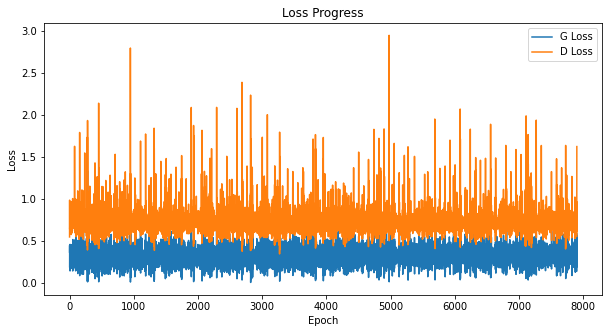

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='G Loss')
plt.plot(loss_hist['dis'], label='D Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
generator.eval()

# fake image 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100,1,1, device=device)
    label = torch.randint(0,10,(16,), device=device)
    img_fake = generator(fixed_noise).detach().cpu()
print(img_fake.shape)

torch.Size([16, 3, 64, 64])


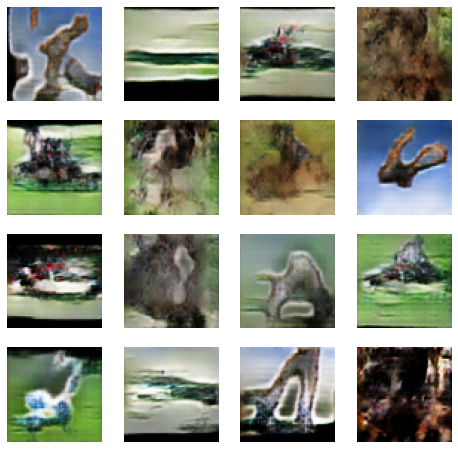

In [ ]:
plt.figure(figsize=(8,8))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(img_fake[ii]*0.5 + 0.5))
    plt.axis('off')